In [1]:
#directories
import os
try:
    parentdir
except NameError:
    parentdir=os.getcwd()
else:
    parentdir = parentdir
homedir=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d14Feb17_60.5_635_A2_CuAzu655';#data directory
print('The working directory is parentdir: %s' %parentdir)
print('The data directory is homedir: %s' %homedir)

The working directory is parentdir: /home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/Azurin_SM_repo/Analysis
The data directory is homedir: /home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d14Feb17_60.5_635_A2_CuAzu655


In [7]:
#Import modules #Run this once

import numpy as np
import pandas as pd
import os.path
from pylab import *
import glob
import os
import re
from xlwt import Workbook
from scipy.optimize import curve_fit
global pointnumber
from numpy import sqrt, pi, exp, linspace, loadtxt
from lmfit import  Model, Parameter, Parameters
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Simulation

## rand_on_off_time

In [2]:
def rand_on_off_times(ton=1, toff1=1, toff2=10, multiplier=100, numpoints=1000):
    '''ton, toff1, toff2 are in millisecond
    multiplier: time resolution
    '''
    #on times
    on_rand_exp = np.random.exponential(ton*multiplier,numpoints);
    on_rand_exp = np.round(on_rand_exp);
    #off times
    off_exp1 = np.random.exponential(toff1*multiplier,numpoints);
    off_exp1 = np.round(off_exp1)
    off_exp2 = np.random.exponential(toff2*multiplier,numpoints);
    off_exp2 = np.round(off_exp2);
    off_rand_exp = off_exp2;
    off_rand_biexp = off_exp2 - off_exp1;
    return on_rand_exp, off_rand_exp,off_rand_biexp

In [205]:
on_rand_exp, off_rand_exp,off_rand_biexp = rand_on_off_times(ton=1, toff1=1, toff2=10,
                                                             multiplier=100, numpoints=10000)
# figure(figsize=(10, 8))
# hist(off_rand_biexp - min(off_rand_biexp), bins=100);

## trace_on_off

In [3]:
def trace_on_off(ton=10, toff1=1, toff2=100, multiplier=1000, numpoints=100,
                oncounts=2500, offcounts=200):
    ''''''
    on_rand_exp, off_rand_exp,off_rand_biexp = rand_on_off_times(ton=ton, toff1=toff1, toff2=toff2,
                                                             multiplier=multiplier, numpoints=numpoints)
    intensity = []
    for i in range(len(off_rand_exp)):
        #on-times
        ran_on = randn(on_rand_exp[i])
        intensity_on = oncounts * np.ones(on_rand_exp[i])
        intensity_on = intensity_on + intensity_on *0.025*ran_on
        intensity = np.concatenate((intensity, intensity_on), axis=0)
        #off time
        ran_off = 3 + randn(off_rand_exp[i])
        intensity_off = offcounts * np.ones(off_rand_exp[i])
        intensity_off = intensity_off + intensity_off*0.25*ran_off
        intensity = np.concatenate((intensity, intensity_off), axis=0)
    time = linspace(1, len(intensity), len(intensity))
    return time, intensity

### time trace plot

(0, 2894.6800280557463)

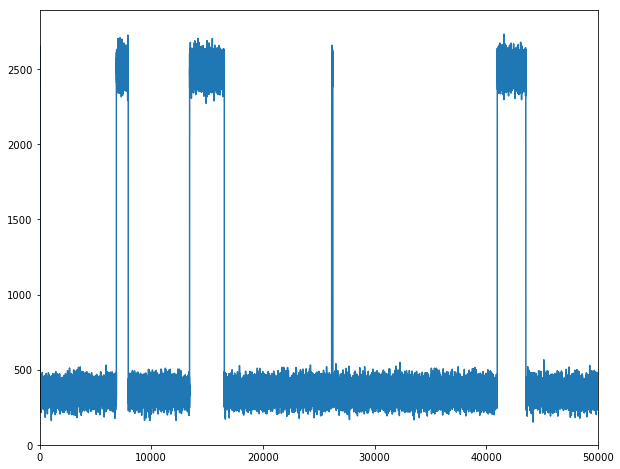

In [6]:
time, intensity = trace_on_off(ton=1, toff1=1, toff2=10, multiplier=1000, numpoints=100)
figure(figsize=(10, 8))
plot(time, intensity)
xlim(0, 50000)
ylim(0, None)

## trace_on_off_blink

In [83]:
def trace_on_off_blink(ton=10, toff1=1, toff2=100, ton_blink=1, toff_blink=0.1, toff_blink2=10,
                       multiplier=1000, numpoints=100,oncounts=2500, offcounts=200):
    ''''''
    on_rand_exp, off_rand_exp,off_rand_biexp = rand_on_off_times(ton=ton, toff1=toff1, toff2=toff2,
                                                             multiplier=multiplier, numpoints=numpoints)
    intensity = []
    for i in range(len(off_rand_exp)):
        #on-times
        ran_on = randn(on_rand_exp[i])
        intensity_on = oncounts * np.ones(on_rand_exp[i])
        
        numofpoints= 10 #len(intensity_on)/()
        on_rand_blink, off_rand_blink, off_rand_blinkbiexp = rand_on_off_times(ton=ton_blink, toff1=toff_blink, toff2=toff_blink2,
                                                                     multiplier=multiplier, numpoints=numofpoints)
        int_blink = []
        for j in range(len(on_rand_blink)):
            int_blink_on = oncounts * np.ones(on_rand_blink[j])#on times
            ran_on_blink = randn(len(int_blink_on))
            int_blink_on = int_blink_on + int_blink_on * ran_on_blink *0.025 #add noise
            int_blink = np.concatenate((int_blink, int_blink_on), axis=0)
            int_blink_off = offcounts * np.ones(off_rand_blink[j]) #off:devide my oncounts to make it 1
            ran_off_blink = 3 + randn(len(int_blink_off))
            int_blink_off = int_blink_off + int_blink_off*ran_off_blink*0.2 # 0.25 is 10 times 0.025
            int_blink = np.concatenate((int_blink, int_blink_off), axis=0)
        if len(intensity_on) < len(int_blink):
            intensity_on[:] = int_blink[:len(intensity_on)]
        else:
            intensity_on[:len(int_blink)] = int_blink[:]
            intensity_on = intensity[:len(int_blink)]
        intensity_on = intensity_on #+ intensity_on *0.025*ran_on
        intensity = np.concatenate((intensity, intensity_on), axis=0)
        #off time
        ran_off = 3 + randn(off_rand_exp[i])
        intensity_off = offcounts * np.ones(off_rand_exp[i])
        intensity_off = intensity_off + intensity_off*0.2*ran_off
        intensity = np.concatenate((intensity, intensity_off), axis=0)
    time = linspace(1, len(intensity), len(intensity))
    return time, intensity

### time trace plot

(0, 2891.5726398628144)

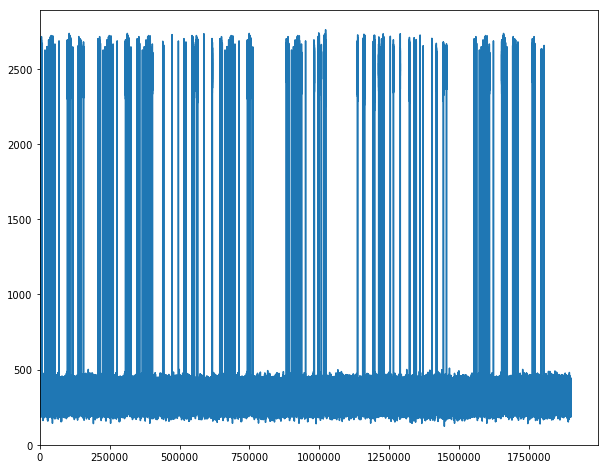

In [92]:
time, intensity = trace_on_off_blink(ton=100, toff1=1, toff2=50, ton_blink=1, toff_blink=0.1, toff_blink2=10,
                       multiplier=1000, numpoints=20,oncounts=2500, offcounts=200)
figure(figsize=(10, 8))
plot(time, intensity)
xlim(0, None)
ylim(0, None)

# Simulated from Experimental data

In [ ]:
#directories
import os
try:
    parentdir
except NameError:
    parentdir=os.getcwd()
else:
    parentdir = parentdir
homedir=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d14Feb17_60.5_635_A2_CuAzu655';#data directory
print('The working directory is parentdir: %s' %parentdir)
print('The data directory is homedir: %s' %homedir)

In [2]:
#Run this once to run the .py file.
os.chdir(parentdir)
!python Analysis_bis.py
%run Analysis_bis.py

In [3]:
#list of folders and their directories CuAZUATTO655
S81d7Sept16_A3_ON_60sec_trace = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160907_CuAzu655_Ferri_Asc_analysis/S81d7Sept16_0.11uW_0.2mMFerri_0.1mM Asc_A3_ON/60sec_trace';
S81d7Sept16_A5_ON = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160907_CuAzu655_Ferri_Asc_analysis/S81d7Sept16_0.11uW_0.2mMFerri_0.1mM Asc_A5_ON';
S83d10Sept16_A3_30sec_trace = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/30sec_trace'
S83d10Sept16_Cu_50mV_300s = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/300sec_trace';

S101d14Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d14Feb17_60.5_635_A2_CuAzu655';
S101d15Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d15Feb17_60.5_635_A2_CuAzu655';
S101d15Feb17_62o2_635_A2_CuAzu655_2nd= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d15Feb17_62.2_635_A2_CuAzu655_2nd';
S101d16Feb17_60o5_635_A3_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d16Feb17_60.5_635_A3_CuAzu655';
S104d20Feb17_60o5_635_A1_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d20Feb17_60.5_635_A1_CuAzu655';
S104d21Feb17_60o5_635_A1_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d21Feb17_60.5_635_A1_CuAzu655';
S104d21Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d21Feb17_60.5_635_A2_CuAzu655';
S105d15May17_60o5_635_A1_CuAzu655_longtime = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S105d15May17_60.5%635_A1_CuAzu655_longtime';
S106d18May17_635_CuAzu655_longtime = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S106d18May17_635_CuAzu655_longtime'
#Combine all folders
allfolders = [S81d7Sept16_A3_ON_60sec_trace, S81d7Sept16_A5_ON,S83d10Sept16_A3_30sec_trace , S101d14Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_62o2_635_A2_CuAzu655_2nd, S101d16Feb17_60o5_635_A3_CuAzu655,
             S104d20Feb17_60o5_635_A1_CuAzu655, S104d21Feb17_60o5_635_A1_CuAzu655, S104d21Feb17_60o5_635_A2_CuAzu655, S105d15May17_60o5_635_A1_CuAzu655_longtime]
fold_201609 = [S81d7Sept16_A3_ON_60sec_trace, S81d7Sept16_A5_ON, S83d10Sept16_A3_30sec_trace, S83d10Sept16_Cu_50mV_300s]
fold_201702 = [S101d14Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_62o2_635_A2_CuAzu655_2nd, S101d16Feb17_60o5_635_A3_CuAzu655];
fold_201705 = [S105d15May17_60o5_635_A1_CuAzu655_longtime, S106d18May17_635_CuAzu655_longtime]

In [4]:
def histogram_on_off_all_folder(folderlist= allfolders, input_potential=[100], pointnumbers=range(100),
                          bins_on=50, range_on=[0, 0.2], bins_off=50, range_off=[0, 0.5], plotting=False):
    t_ons = []; t_offs = [];
    for folder in folderlist:
        df_datn_emplot, df_FCS, folder = dir_mV_molNo(folder)
        df_specific = df_datn_emplot[df_datn_emplot['Point number'].isin(pointnumbers)]#keep all the points that exist
        df_specific = df_specific[df_specific['Potential'].isin(input_potential)]; df_specific.reset_index(drop=True, inplace=True)
        for i in range(len(df_specific)):
            Point_number = df_specific['Point number'][i]
            f_datn_path = df_specific['filepath[.datn]'].values[i]
            f_emplot_path = df_specific['filepath[.em.plot]'].values[i]
            df_emplot_filename = df_specific['filename[.em.plot]'][i]
            if os.path.isfile(f_emplot_path):
                try:
                    df_ton, df_toff, average_ton, average_toff, average_ton_err, average_toff_err = t_on_off_fromCP(f_datn_path, f_emplot_path)
                except:
                    print('em.plot file: %s doesn''t contain proper data' %df_emplot_filename)
                    df_ton=[]; df_toff=[]
                    pass
            else:
                print('em.plot file of %s with potential %s doesn''t exist' %(Point_number, input_potential))
                df_ton=[]; df_toff=[]
            t_ons = np.concatenate((t_ons, df_ton), axis=0);
            t_offs = np.concatenate((t_offs, df_toff));
    if plotting == True:
        fig, axes = plt.subplots(1, 2, figsize=(20,8))
        n_on,bins_on,patches = axes[0].hist(t_ons, range=range_on,bins=bins_on)
        axes[0].set_xlabel(r'$\tau_{on}$')
        axes[0].set_ylabel('#')
        #axes[0].set_yscale('log')
        axes[0].set_title("ON time histogram at %s mV" %input_potential[0])
        n_off,bins_off,patches = axes[1].hist(t_offs, range=range_off,bins=bins_off)
        axes[1].set_xlabel(r'$\tau_{off}$')
        axes[1].set_ylabel('#')
        #axes[1].set_yscale('log')
        axes[1].set_title("OFF time histogram at %s mV" %input_potential[0])
    return(t_ons, t_offs, n_on, bins_on, n_off, bins_off)

In [ ]:
def hist_2d_from_t_values(t_ons, t_offs,input_potential=100, x_shift=10, bins_on=40, range_on=[0, 0.01], bins_off=50, range_off=[0, 1], plots = True):
    t_ons=pd.Series(t_ons);t_offs=pd.Series(t_offs)
    t_on_shifted_1 = t_ons.shift(+1) ## shift up
    t_on_delay_1 = pd.DataFrame([t_on_shifted_1, t_ons]); t_on_delay_1=t_on_delay_1.T
    t_on_delay_1 = t_on_delay_1.dropna();
    t_off_shifted_1 = t_offs.shift(+1) ## shift up

    t_on_shifted_x = t_ons.shift(+x_shift) ## shift up
    t_off_shifted_x = t_offs.shift(+x_shift) ## shift up
    print('Number of on events: %d' %len(t_ons))
    print('Number of off events: %d' %len(t_offs))
    if plots==True:
        import matplotlib as mpl
        colormap=mpl.cm.RdBu_r
        fig = plt.figure(figsize=(16,8))

        ax1 = fig.add_subplot(2,3,1)#2,2,1
        C_on_1,Ex_on_1,Ey_on_1, figu = hist2d(t_on_shifted_1[1:], t_ons[1:], range=[range_on, range_on], bins=bins_on, norm=mpl.colors.LogNorm(), cmap=colormap)
        Ex_on_1,Ey_on_1 = meshgrid(Ex_on_1,Ey_on_1)
        #ax1.pcolormesh(Ex_on_1, Ey_on_1, C_on_1, cmap=colormap)#,norm=mpl.colors.LogNorm()
        colorbar()
        ax1.set_title('ON time Cu-Azu %smV' %input_potential)
        ax1.set_xlabel(r'$\tau_{on}/s$')
        ax1.set_ylabel(r'$\tau_{on}+1/s$')

        ax2 = fig.add_subplot(2,3,2)#2,2,1
        C_on_x,Ex_on_x,Ey_on_x, figu = hist2d(t_on_shifted_x[x_shift:], t_ons[x_shift:], range=[range_on, range_on], bins=bins_on, norm=mpl.colors.LogNorm(), cmap=colormap)
        Ex_on_x,Ey_on_x = meshgrid(Ex_on_x,Ey_on_x)
        #ax2.pcolormesh(Ex_on_x, Ey_on_x, C_on_x, cmap=colormap)#,norm=mpl.colors.LogNorm()
        colorbar()
        ax2.set_title('ON time Cu-Azu %smV' %input_potential)
        ax2.set_xlabel(r'$\tau_{on}/s$')
        ax2.set_ylabel(r'$\tau_{on}+%s/s$'%x_shift)

        ax3 = fig.add_subplot(2,3,3)
        C_on_diff = C_on_1-C_on_x;
        pcm=ax3.pcolormesh(Ex_on_x, Ey_on_x, C_on_diff,
                       norm=mpl.colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=C_on_diff.min(), vmax=C_on_diff.max()), cmap=colormap)
        fig.colorbar(pcm, ax=ax3, extend='max')

        ax4 = fig.add_subplot(2,3,4)
        C_off_1, Ex_off_1, Ey_off_1, figu= hist2d(t_off_shifted_1[1:], t_offs[1:], range=[range_off, range_off],bins=bins_off, norm=mpl.colors.LogNorm(), cmap=colormap);#, norm=mpl.colors.LogNorm()
        Ex_off_1, Ey_off_1 = meshgrid(Ex_off_1, Ey_off_1)
        colorbar()
        ax4.set_title('OFF time Cu-Azu %smV' %input_potential)
        ax4.set_xlabel(r'$\tau_{off}/s$')
        ax4.set_ylabel(r'$\tau_{off}+1/s$')

        ax5 = fig.add_subplot(2,3,5)
        C_off_x,Ex_off_x,Ey_off_x, figu = hist2d(t_off_shifted_x[x_shift:], t_offs[x_shift:], range=[range_off, range_off],bins=bins_off, norm=mpl.colors.LogNorm(), cmap=colormap);#, norm=mpl.colors.LogNorm()
        Ex_off_x,Ey_off_x = meshgrid(Ex_off_x,Ey_off_x)
        colorbar()
        ax5.set_title('OFF time Cu-Azu %smV' %input_potential)
        ax5.set_xlabel(r'$\tau_{off}/s$')
        ax5.set_ylabel(r'$\tau_{off}+%s/s$'%x_shift)

        ax6 = fig.add_subplot(2,3,6)
        C_off_diff=C_off_1-C_off_x
        pcm=ax6.pcolormesh(Ex_off_x, Ey_off_x, C_off_diff, norm=mpl.colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=C_off_diff.min(), vmax=C_off_diff.max()), cmap=colormap)
        fig.colorbar(pcm, ax=ax6, extend='max')
        plt.tight_layout()
        return()

Generating on off times from the distribution (probability distribution function) obtained in the experiment.
Resonable paramters:
100 mV: bins_on=200, range_on=[0, 0.04], bins_off=200, range_off=[0, 1]


em.plot file of 2.0 with potential [100] doesnt exist
em.plot file of 15.0 with potential [100] doesnt exist


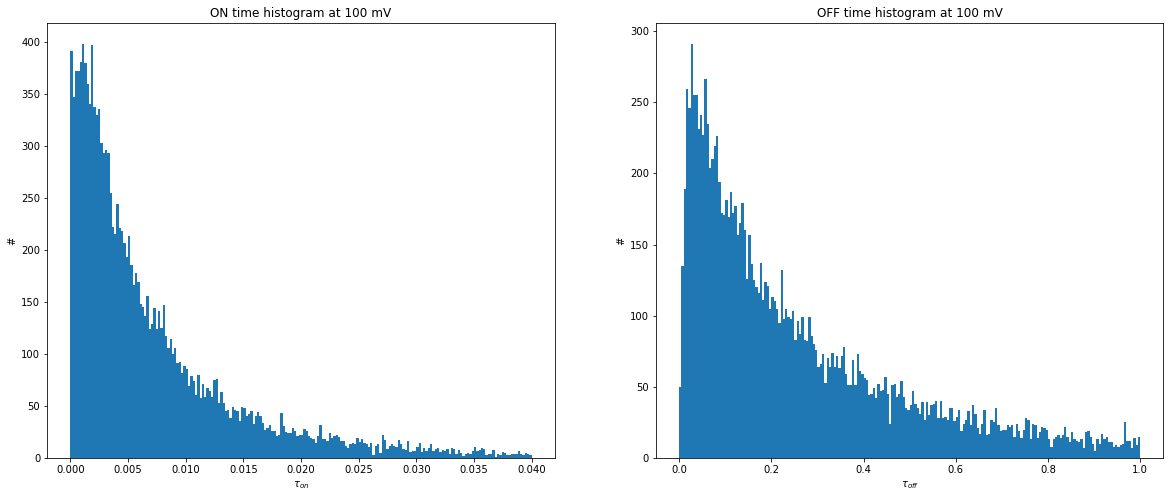

In [30]:
#
t_ons, t_offs, n_on, bins_on, n_off, bins_off = histogram_on_off_all_folder(folderlist= allfolders, input_potential=[100], pointnumbers=range(100), 
                                        bins_on=200, range_on=[0, 0.04], bins_off=200, range_off=[0, 1], plotting=True)

prob_on = n_on/max(n_on); prob_on = prob_on/sum(prob_on);
prob_off = n_off/max(n_off); prob_off = prob_off/sum(prob_off);
data_points = 1e6
t_ons_generated = np.random.choice(bins_on[:-1], data_points, p=prob_on)
t_off_generated = np.random.choice(bins_off[:-1], data_points, p=prob_off)

Number of on events: 1000000
Number of off events: 1000000


()

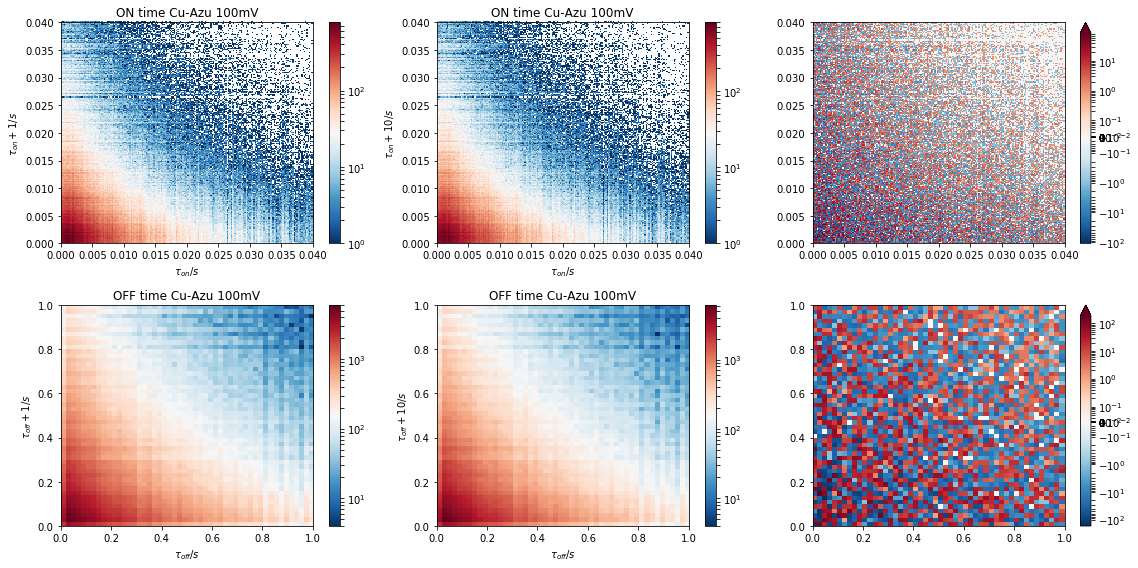

In [32]:
hist_2d_from_t_values(t_ons_generated, t_off_generated, x_shift=10, bins_on=200, range_on=[0, 0.04], bins_off=50, range_off=[0, 1], plots = True)